In [1]:
import time

import torch
from torchvision import datasets
import torchvision.transforms as transforms

from dataset import CustomImageDataset, AugmentedImageDataset, MakeDataLoaders

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


## Dataset and DataLoader

### Load the custom dataset

In [2]:
# load dataset from custom class
trainset = AugmentedImageDataset()

# create dataloader
batch_size = 64
loader = MakeDataLoaders(trainset, batch_size, 2)
train_loader = loader.loader  # DataLoader object

Files already downloaded and verified


In [4]:
start = time.time()
for batch_idx, data in enumerate(train_loader):
    if batch_idx % 10 == 0:
        print("[%d] %.2f seconds" % (batch_idx, time.time()-start))
        start = time.time()

    if batch_idx == 50:
        break

[0] 6.74 seconds
[10] 0.43 seconds
[20] 0.54 seconds
[30] 0.55 seconds
[40] 0.58 seconds
[50] 0.53 seconds


### Dataset inspection

In [ ]:
print("Number of samples:", len(trainset))
print("View 1:", trainset[0][0].shape)
print("View 2:", trainset[0][1].shape)
print("Label:", trainset[0][2])

Files already downloaded and verified
Number of samples: 50000
View 1: torch.Size([3, 32, 32])
View 2: torch.Size([3, 32, 32])
Label: 6


In [ ]:
view1, view2, label = next(iter(train_loader))

print(f"View 1 batch shape, (first augmentation): {view1.size()}")
print(f"View 1 batch shape, (second augmentation): {view2.size()}")
print(f"Label batch shape: {label.size()}")

View 1 batch shape, (first augmentation): torch.Size([64, 3, 32, 32])
View 1 batch shape, (second augmentation): torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


In [20]:
import matplotlib.pyplot as plt
def plot_views(img0, img1, img2, label, dir):

    fig, axs = plt.subplots(1, 3, layout="constrained")

    images = [img0, img1, img2]
    titles = [f"Original - label {label}", "First augmentation", "Second augmentation"]
    for i in range(3):
        axs[i].imshow(images[i], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(titles[i])

    plt.savefig(dir)
    plt.show()

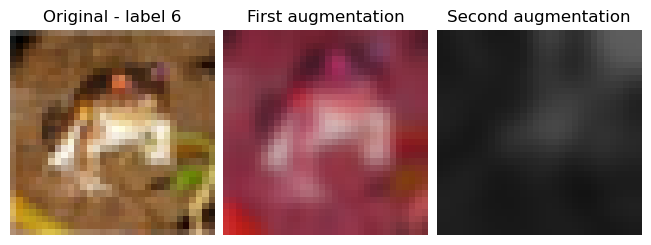

In [21]:
import matplotlib.pyplot as plt

# two version of the first image of the trainig set
img0 = trainset.dataset.data[0]
img1 = torch.permute(trainset[0][0], (1, 2, 0))
img2 = torch.permute(trainset[0][1], (1, 2, 0))
label = trainset[0][2]

plot_views(img0, img1, img2, label, "./plots/original_views.pdf")


In [ ]:
## Show original images and their two augmented versions

# Andare a stampare immagini originali e trasformazioni
# Running multiple times yields different views
# augmentation is performed online
from torchvision.utils import make_grid
pics = 10
imgs = torch.stack((*[transforms.ToTensor()(trainset.dataset[i][0]) for i in range(pics)],
                    *[trainset[i][0] for i in range(pics)],
                    *[trainset[i][1] for i in range(pics)]))

grid = make_grid(imgs, nrow=pics)

image = transforms.ToPILImage()(grid)
image.show()
image.save("./plots/views.png")

In [10]:
# quick training loop over 3 batches
for idx, data in enumerate(train_loader):
    image1, image2, targets = data
    print(image1.shape)
    print(image2.shape)
    print(targets.shape)
    print()
    if idx == 2:
        break

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64])

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64])

torch.Size([64, 3, 32, 32])
torch.Size([64, 3, 32, 32])
torch.Size([64])



### Inspect batches

In [11]:
def plot_pairs(img0, img0_pos, img0_neg, label_pos, label_neg):
    fig, axs = plt.subplots(1, 3, layout="constrained")

    axs[0].imshow(img0, cmap="gray")
    axs[0].axis("off")
    axs[0].set_title(f"Original - label {label_pos}")

    axs[1].imshow(img0_pos, cmap="gray")
    axs[1].axis("off")
    axs[1].set_title("Positive pair")

    axs[2].imshow(img0_neg, cmap="gray")
    axs[2].axis("off")
    axs[2].set_title(f"Negative pair {label_neg}")

    plt.show()

tensor(1)
tensor(9)


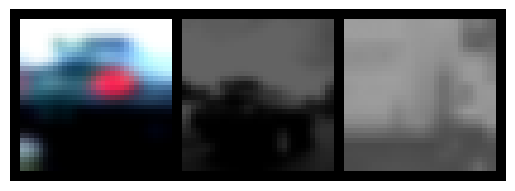

tensor(1)
tensor(3)


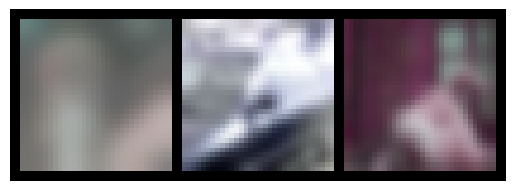

tensor(1)
tensor(7)


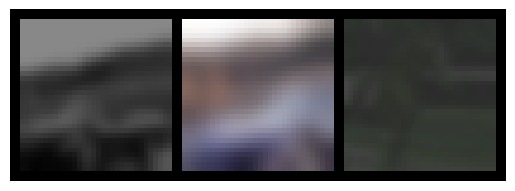

tensor(1)
tensor(7)


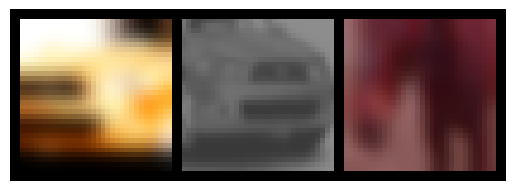

In [12]:
method = "Supervised"
x = 0
label = 1

for idx, data in enumerate(train_loader):
    image1, image2, targets = data

    ## Unsupervised method
    if method == "Unsupervised":
        # img0 = torch.permute(image1[x], (1, 2, 0))
        img0 = image1[x]
        # img0_pos = torch.permute(image2[x], (1, 2, 0))
        img0_pos = image2[x]
        # img0_neg = torch.permute(image1[x+1], (1, 2, 0))
        img0_neg = image1[x+1]

        label_pos = targets[x]
        print(label_pos)
        label_neg = targets[x+1]
        print(label_neg)

    ## Supervised method
    elif method == "Supervised":
        indices = targets == label
        img0 = image1[indices][x]
        img0_pos = image2[indices][x]
        img0_neg = image1[~indices][x]

        label_pos = targets[indices][x]
        print(label_pos)
        label_neg = targets[~indices][x]
        print(label_neg)

    grid = make_grid([img0, img0_pos, img0_neg], nrow=3)
    plt.figure()
    plt.imshow(grid.permute(1, 2, 0))
    # plt.title()
    plt.axis("off")
    plt.show()

    if idx == 3:
        break

## Siamese network

In [4]:
import torch.optim as optim
import torchvision.models as models

from nets import SiameseNetSync, SiameseNetAsync

backbone = models.resnet18()

Sync training

In [ ]:
# Check output shape
sync_out = SiameseNetSync(backbone)(torch.randn(5, 3, 32, 32), torch.randn(5, 3, 32, 32))
print(sync_out["view1"].shape)
print(sync_out["view2"].shape)

torch.Size([5, 512])
torch.Size([5, 512])


Async training

In [6]:
# Check output shape
async_dict = SiameseNetAsync(backbone)(torch.randn(5, 3, 32, 32), torch.randn(5, 3, 32, 32))
print(async_dict["view1"].shape)
print(async_dict["view2"].shape)

torch.Size([5, 512])
torch.Size([5, 512])


Training loop

In [8]:
backbone = models.resnet18()
model = SiameseNetSync(backbone)

for idx, data in enumerate(train_loader):
    view1, view2, targets = data

    print(f"First augmentation: {view1.shape}")
    print(f"Second augmentation: {view2.shape}")
    print(f"Targets: {targets.shape}")

    ## Forward pass
    output = model(view1, view2)
    print("Forward on view1:", output["view1"].shape)
    print(f"Forward on view2:", output["view2"].shape)

    if idx == 0:
        break

First augmentation: torch.Size([64, 3, 32, 32])
Second augmentation: torch.Size([64, 3, 32, 32])
Targets: torch.Size([64])
Forward on view1: torch.Size([64, 512])
Forward on view2: torch.Size([64, 512])


## Contrastive learning

In [ ]:
import torch.optim as optim
import torchvision.models as models

from nets import SiameseNetSync as SiameseNet
from infonce import ContrastiveLoss

Device: cuda


In [4]:
backbone = models.resnet18()
model = SiameseNet(backbone)
model = model.to(device)

optimizer = optim.Adam(model.parameters())
criterion = ContrastiveLoss()

In [ ]:
import time
import numpy as np

# epoch_losses = []
max_epochs = 1

start = time.time()
for epoch in range(max_epochs):
    losses = []
    for idx, data in enumerate(train_loader):
        view1, view2, _ = data
        view1, view2 = view1.to(device), view2.to(device)
        # print(view1.shape)
        # print(targets.shape)

        optimizer.zero_grad()

        output = model(view1, view2)
        output1, output2 = output.values()
        # print("Views size", output1.shape, output2.shape)

        # accoda gli embedding delle view1 e delle view2
        features = torch.cat((output1, output2), dim=0)
        # print("Features shape", features.shape)

        # update model
        loss = criterion(features)
        loss.backward()
        optimizer.step()

        losses.append(loss.detach().cpu().numpy())

        if idx == 20:
            iter_loss = np.mean(losses[-idx:])
            print("[%d/%d] [%d/%d] | Loss: %.4f | %.2f seconds"
                  % (epoch+1, max_epochs, idx, len(train_loader),
                     loss.item(), time.time()-start))
            start = time.time()

    # epoch_losses.append(np.mean(losses))

IndexError: list index out of range

## Self-distillation

In [ ]:
import torch.optim as optim
import torchvision.models as models

# from nets import SiameseNetAsync as SiameseNet
from byol import BYOL

In [4]:
backbone = models.resnet18()
model = BYOL(backbone)
model = model.to(device)

In [5]:
online_params = [{
    "params": model.online_net.parameters(),  # parametri dell'encoder
    "params": model.online_projector.parameters()  # parametri del projector aggiuntivo
}]

optim_online = optim.SGD(
    online_params,  # online net: encoder + projector
    lr=0.001
)

In [6]:
import time
import numpy as np

start = time.time()
max_epochs = 2

for epoch in range(max_epochs):
    losses = []
    for idx, data in enumerate(train_loader):
        view1, view2, _ = data
        view1, view2 = view1.to(device), view2.to(device)
        # print(f"First augmentation: {view1.shape}")  # [64, 3, 32, 32]
        # print(f"Second augmentation: {view2.shape}")  # [64, 3, 32, 32]
        # print(f"Targets: {targets.shape}")  # [64]

        ## Update Online network
        optim_online.zero_grad()
        loss = model(view1, view2)  # vengono feedate le view a coppie
        loss.backward()  # solo sulla rete Online
        optim_online.step()  # aggiorna i parametri di Online
        losses.append(loss.detach().cpu().numpy())

        ## Update Target network
        model.update_moving_average()  # aggiornamento basato su EMA

        ## Diagnostic
        if idx % 100 == 0:
            iter_loss = np.mean(losses[-idx:])
            print("[%d/%d] [%d/%d] | Loss: %.4f | %.2f seconds"
                  % (epoch+1, max_epochs, idx, len(train_loader),
                     loss.item(), time.time()-start))
            start = time.time()

[1/2] [0/782] | Loss: 3.9823 | 6.15 seconds
[1/2] [100/782] | Loss: 1.9378 | 5.54 seconds
[1/2] [200/782] | Loss: 1.7438 | 5.62 seconds
[1/2] [300/782] | Loss: 1.6702 | 5.62 seconds
[1/2] [400/782] | Loss: 1.6320 | 5.56 seconds
[1/2] [500/782] | Loss: 1.5937 | 5.65 seconds
[1/2] [600/782] | Loss: 1.5716 | 5.64 seconds
[1/2] [700/782] | Loss: 1.5662 | 5.72 seconds
[2/2] [0/782] | Loss: 1.5551 | 10.62 seconds
[2/2] [100/782] | Loss: 1.5466 | 5.65 seconds
[2/2] [200/782] | Loss: 1.5374 | 5.86 seconds
[2/2] [300/782] | Loss: 1.5269 | 5.66 seconds
[2/2] [400/782] | Loss: 1.5312 | 6.39 seconds
[2/2] [500/782] | Loss: 1.5104 | 7.99 seconds
[2/2] [600/782] | Loss: 1.5015 | 8.17 seconds
[2/2] [700/782] | Loss: 1.4995 | 7.19 seconds


## Canonical correlation analysis

In [3]:
import torch.optim as optim
import torchvision.models as models

from nets import SiameseNetSync as SiameseNet
from barlow import BarlowTwins

In [4]:
backbone = models.resnet18()
model = SiameseNet(backbone)
criterion = BarlowTwins(0.005)

model = model.to(device)
criterion = criterion.to(device)

In [5]:
params = [{
    "params": model.parameters(),  # parametri dell'encoder
    "params": criterion.projector.parameters(),  # parametri del projector aggiuntivo
    "params": criterion.bn.parameters()
}]

optimizer = optim.Adam(params, lr=0.0001)  # params della Siamese + MLP

In [6]:
import time
import numpy as np

start = time.time()
losses = []
max_epochs = 5

for epoch in range(max_epochs):
  for idx, data in enumerate(train_loader):
      view1, view2, _ = data
      view1, view2 = view1.to(device), view2.to(device)
      # print(view1.shape, view2.shape)

      optimizer.zero_grad()
      output = model(view1, view2)
      features1, features2 = output['view1'], output['view2']
      # print(features1.shape, features2.shape)
      loss = criterion(features1, features2)
      loss.backward()
      optimizer.step()

      losses.append(loss.detach().cpu().item())

      if idx % 100 == 0:
          iter_loss = np.mean(losses[-idx:])
          print("[%d/%d] [%d/%d] | Loss: %.4f | %.2f seconds"
                % (epoch+1, max_epochs, idx, len(train_loader),
                    loss.item(), time.time()-start))
          start = time.time()

[1/5] [0/782] | Loss: 2048.4785 | 6.48 seconds
[1/5] [100/782] | Loss: 2046.2377 | 5.68 seconds
[1/5] [200/782] | Loss: 2047.4258 | 5.56 seconds
[1/5] [300/782] | Loss: 2046.7380 | 5.50 seconds
[1/5] [400/782] | Loss: 2046.1104 | 5.73 seconds
[1/5] [500/782] | Loss: 2044.8304 | 5.80 seconds
[1/5] [600/782] | Loss: 2046.0547 | 5.90 seconds
[1/5] [700/782] | Loss: 2044.7344 | 5.68 seconds
[2/5] [0/782] | Loss: 2045.1733 | 10.71 seconds
[2/5] [100/782] | Loss: 2047.8765 | 5.61 seconds
[2/5] [200/782] | Loss: 2047.2047 | 5.50 seconds
[2/5] [300/782] | Loss: 2047.1049 | 5.54 seconds
[2/5] [400/782] | Loss: 2044.8394 | 5.53 seconds
[2/5] [500/782] | Loss: 2044.0481 | 5.49 seconds
[2/5] [600/782] | Loss: 2044.8923 | 5.52 seconds
[2/5] [700/782] | Loss: 2046.7181 | 5.50 seconds
[3/5] [0/782] | Loss: 2046.0654 | 11.58 seconds
[3/5] [100/782] | Loss: 2049.0728 | 6.52 seconds
[3/5] [200/782] | Loss: 2044.3668 | 6.43 seconds
[3/5] [300/782] | Loss: 2048.7395 | 6.02 seconds
[3/5] [400/782] | Loss: 

KeyboardInterrupt: 